# Imports

In [ ]:
import tensorflow as tf                                
from tensorflow import keras             
import numpy as np                       
from sklearn.model_selection import train_test_split   
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape, LSTM, ConvLSTM2D, Permute, TimeDistributed
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, concatenate
from tensorflow.keras.models import Model
import os

# Default Project

## 1. Optimize the classification accuracy for subject 1. Does it help to train across all subjects?

#### Preprocessing

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    # print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    # print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    # print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y



In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

subject = 0
subject_test_idx = np.where(person_test==subject)[0]
subject_valid_idx = np.where(person_train_valid==subject)[0]


subject_X_test = X_test[subject_test_idx]
suject_y_test = y_test[subject_test_idx]
suject_X_train_valid = X_train_valid[subject_valid_idx]
suject_y_train_valid = y_train_valid[subject_valid_idx]

print(f'X_test Shape for Subject {subject}: {subject_X_test.shape}')
print(f'y_test Shape for Subject {subject}: {suject_y_test.shape}')
print(f'X_train_valid Shape for Subject {subject}: {suject_X_train_valid.shape}')
print(f'y_train_valid Shape for Subject {subject}: {suject_y_train_valid.shape}')




X_test Shape for Subject 0: (50, 22, 1000)
y_test Shape for Subject 0: (50,)
X_train_valid Shape for Subject 0: (237, 22, 1000)
y_train_valid Shape for Subject 0: (237,)


In [ ]:
# shuffle with 5 fold
indicies_valid = np.random.choice(suject_X_train_valid.shape[0], suject_X_train_valid.shape[0] // 5, replace=False)
indicies_train = np.array(list(set(range(suject_X_train_valid.shape[0])).difference(set(indicies_valid))))

# Creating the training and validation sets using the generated indices
X_train, X_valid = suject_X_train_valid[indicies_train], suject_X_train_valid[indicies_valid] 
y_train, y_valid = suject_y_train_valid[indicies_train], suject_y_train_valid[indicies_valid]


# Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(subject_X_test,suject_y_test,2,2,True)



print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)



Shape of training set: (760, 22, 250)
Shape of validation set: (188, 22, 250)
Shape of training labels: (760,)
Shape of validation labels: (188,)
Shape of testing set: (200, 22, 250)
Shape of testing labels: (200,)
Shape of training labels after categorical conversion: (760, 4)
Shape of validation labels after categorical conversion: (188, 4)
Shape of test labels after categorical conversion: (200, 4)
Shape of training set after adding width info: (760, 22, 250, 1)
Shape of validation set after adding width info: (188, 22, 250, 1)
Shape of test set after adding width info: (200, 22, 250, 1)
Shape of training set after dimension reshaping: (760, 250, 1, 22)
Shape of validation set after dimension reshaping: (188, 250, 1, 22)
Shape of test set after dimension reshaping: (200, 250, 1, 22)


#### Model

In [ ]:

# Building the CNN model using sequential class
cnn_subject_model = Sequential()

# Conv. block 1
cnn_subject_model.add(Conv2D(filters=10, kernel_size=(5,1), padding='same', activation='elu', input_shape=(250,1,22)))
cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
cnn_subject_model.add(BatchNormalization())
cnn_subject_model.add(Dropout(0.5))

# Conv. block 2
cnn_subject_model.add(Conv2D(filters=10, kernel_size=(15,1), padding='same', activation='elu'))
cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_subject_model.add(BatchNormalization())
cnn_subject_model.add(Dropout(0.5))

# Output layer with Softmax activation
cnn_subject_model.add(Flatten()) # Flattens the input
cnn_subject_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
cnn_subject_model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 250, 1, 10)        1110      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 84, 1, 10)        0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 84, 1, 10)        40        
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 84, 1, 10)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 1, 10)         1510      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 1, 10)       

#### Hyperparameters

In [ ]:
learning_rate = 1e-3
epochs = 100
cnn_subject_model_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

#### Training

In [ ]:
cnn_subject_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_subject_model_optimizer,
                 metrics=['accuracy'])

cnn_subject_model_results = cnn_subject_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True
             )


Epoch 1/100
12/12 [==============================] - 1s 22ms/step - loss: 2.1012 - accuracy: 0.3053 - val_loss: 5.7088 - val_accuracy: 0.2872
Epoch 2/100
12/12 [==============================] - 0s 12ms/step - loss: 1.9649 - accuracy: 0.3382 - val_loss: 3.7922 - val_accuracy: 0.3032
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 1.8282 - accuracy: 0.3487 - val_loss: 2.8641 - val_accuracy: 0.3351
Epoch 4/100
12/12 [==============================] - 0s 11ms/step - loss: 1.6714 - accuracy: 0.3776 - val_loss: 2.2715 - val_accuracy: 0.3617
Epoch 5/100
12/12 [==============================] - 0s 12ms/step - loss: 1.4687 - accuracy: 0.4250 - val_loss: 1.9499 - val_accuracy: 0.3617
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 1.3964 - accuracy: 0.4605 - val_loss: 1.7824 - val_accuracy: 0.3777
Epoch 7/100
12/12 [==============================] - 0s 11ms/step - loss: 1.3930 - accuracy: 0.4289 - val_loss: 1.5789 - val_accuracy: 0.4096
Epoch 

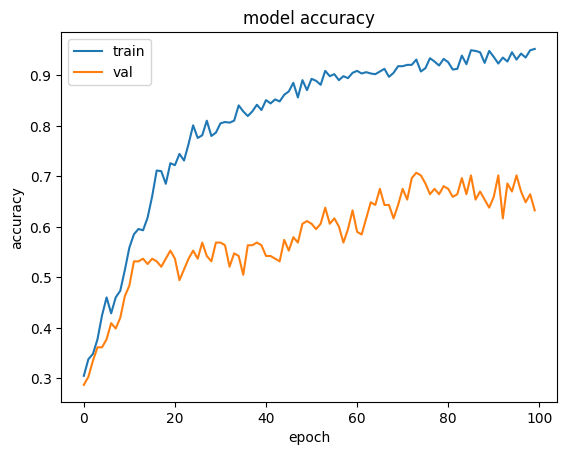

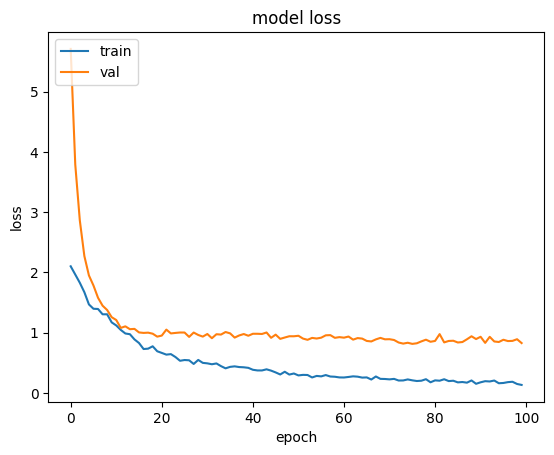

In [ ]:
# summarize history for accuracy
plt.plot(cnn_subject_model_results.history['accuracy'])
plt.plot(cnn_subject_model_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnn_subject_model_results.history['loss'])
plt.plot(cnn_subject_model_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Testing

In [ ]:
cnn_subject_model_score = cnn_subject_model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy of the CNN model for subject {subject}:',cnn_subject_model_score[1])

Test accuracy of the CNN model for subject 0: 0.75


## 1.2 Now Training across all subjects

#### Preprocessing

In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

subject = 0
subject_test_idx = np.where(person_test==subject)[0]
subject_valid_idx = np.where(person_train_valid==subject)[0]


subject_X_test = X_test[subject_test_idx]
suject_y_test = y_test[subject_test_idx]
suject_X_train_valid = X_train_valid[subject_valid_idx]
suject_y_train_valid = y_train_valid[subject_valid_idx]

print(f'X_test Shape for Subject {subject}: {subject_X_test.shape}')
print(f'y_test Shape for Subject {subject}: {suject_y_test.shape}')
print(f'X_train_valid Shape for Subject {subject}: {suject_X_train_valid.shape}')
print(f'y_train_valid Shape for Subject {subject}: {suject_y_train_valid.shape}')

# shuffle with 5 fold
indicies_valid = np.random.choice(X_train_valid.shape[0], X_train_valid.shape[0] // 5, replace=False)
indicies_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(indicies_valid))))

# Creating the training and validation sets using the generated indices
X_train, X_valid = X_train_valid[indicies_train], X_train_valid[indicies_valid] 
y_train, y_valid = y_train_valid[indicies_train], y_train_valid[indicies_valid]


# Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(subject_X_test,suject_y_test,2,2,True)



print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)



X_test Shape for Subject 0: (50, 22, 1000)
y_test Shape for Subject 0: (50,)
X_train_valid Shape for Subject 0: (237, 22, 1000)
y_train_valid Shape for Subject 0: (237,)
Shape of training set: (6768, 22, 250)
Shape of validation set: (1692, 22, 250)
Shape of training labels: (6768,)
Shape of validation labels: (1692,)
Shape of testing set: (200, 22, 250)
Shape of testing labels: (200,)
Shape of training labels after categorical conversion: (6768, 4)
Shape of validation labels after categorical conversion: (1692, 4)
Shape of test labels after categorical conversion: (200, 4)
Shape of training set after adding width info: (6768, 22, 250, 1)
Shape of validation set after adding width info: (1692, 22, 250, 1)
Shape of test set after adding width info: (200, 22, 250, 1)
Shape of training set after dimension reshaping: (6768, 250, 1, 22)
Shape of validation set after dimension reshaping: (1692, 250, 1, 22)
Shape of test set after dimension reshaping: (200, 250, 1, 22)


#### Model

In [ ]:

# Building the CNN model using sequential class
cnn_subject_model = Sequential()

# Conv. block 1
cnn_subject_model.add(Conv2D(filters=10, kernel_size=(5,1), padding='same', activation='elu', input_shape=(250,1,22)))
cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
cnn_subject_model.add(BatchNormalization())
cnn_subject_model.add(Dropout(0.5))

# Conv. block 2
cnn_subject_model.add(Conv2D(filters=10, kernel_size=(15,1), padding='same', activation='elu'))
cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_subject_model.add(BatchNormalization())
cnn_subject_model.add(Dropout(0.5))


# Output layer with Softmax activation
cnn_subject_model.add(Flatten()) # Flattens the input
cnn_subject_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
cnn_subject_model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 250, 1, 10)        1110      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 84, 1, 10)        0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 84, 1, 10)        40        
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 84, 1, 10)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 1, 10)         1510      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 1, 10)       

#### Hyperparameters

In [ ]:
learning_rate = 1e-3
epochs = 100
cnn_subject_model_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

#### Training

In [ ]:
cnn_subject_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_subject_model_optimizer,
                 metrics=['accuracy'])

cnn_subject_model_results = cnn_subject_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/100
106/106 [==============================] - 1s 9ms/step - loss: 2.0054 - accuracy: 0.2858 - val_loss: 1.4232 - val_accuracy: 0.3700
Epoch 2/100
 32/106 [========>.....................] - ETA: 0s - loss: 1.6796 - accuracy: 0.3188

KeyboardInterrupt: 

#### Testing

In [ ]:
cnn_subject_model_score = cnn_subject_model.evaluate(x_test, y_test, verbose=False)
print(f'Test accuracy of the CNN model for subject {subject}:',cnn_subject_model_score[1])


Test accuracy of the CNN model for subject 0: 0.6449999809265137


## 2. Optimize the classification accuracy across all subjects. How does the classifier do? Do you notice any interesting trends?

#### Preprocessing

In [ ]:
def preprocess_subjects(subject):
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    person_train_valid = np.load("person_train_valid.npy")
    X_train_valid = np.load("X_train_valid.npy")
    y_train_valid = np.load("y_train_valid.npy")
    person_test = np.load("person_test.npy")

    ## Adjusting the labels so that 

    # Cue onset left - 0
    # Cue onset right - 1
    # Cue onset foot - 2
    # Cue onset tongue - 3

    y_train_valid -= 769
    y_test -= 769
    


    subject_test_idx = np.where(person_test==subject)[0]
    subject_valid_idx = np.where(person_train_valid==subject)[0]


    subject_X_test = X_test[subject_test_idx]
    suject_y_test = y_test[subject_test_idx]
    suject_X_train_valid = X_train_valid[subject_valid_idx]
    suject_y_train_valid = y_train_valid[subject_valid_idx]


    # shuffle with 5 fold
    indicies_valid = np.random.choice(X_train_valid.shape[0], X_train_valid.shape[0] // 5, replace=False)
    indicies_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(indicies_valid))))

    # Creating the training and validation sets using the generated indices
    X_train, X_valid = X_train_valid[indicies_train], X_train_valid[indicies_valid] 
    y_train, y_valid = y_train_valid[indicies_train], y_train_valid[indicies_valid]


    # Preprocessing the dataset
    x_train,y_train = data_prep(X_train,y_train,2,2,True)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
    X_test_prep,y_test_prep = data_prep(subject_X_test,suject_y_test,2,2,True)



    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)


    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)

    return (x_train, y_train, x_valid, y_valid, x_test, y_test)




#### Model

In [ ]:
learning_rate = 1e-3
epochs = 100
cnn_subject_model_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

x_train, y_train, x_valid, y_valid, _, _ = preprocess_subjects(subject=2)

# Building the CNN model using sequential class
cnn_subject_model = Sequential()

# Conv. block 1
cnn_subject_model.add(Conv2D(filters=20, kernel_size=(5,1), padding='same', activation='elu', input_shape=(250,1,22)))
cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
cnn_subject_model.add(BatchNormalization())
cnn_subject_model.add(Dropout(0.5))

# Conv. block 2
cnn_subject_model.add(Conv2D(filters=20, kernel_size=(15,1), padding='same', activation='elu'))
cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_subject_model.add(BatchNormalization())
cnn_subject_model.add(Dropout(0.5))

# Conv. block 3
cnn_subject_model.add(Conv2D(filters=10, kernel_size=(10,1), padding='same', activation='elu'))
cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_subject_model.add(BatchNormalization())
cnn_subject_model.add(Dropout(0.5))


# Output layer with Softmax activation
cnn_subject_model.add(Flatten()) # Flattens the input
cnn_subject_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

Epoch 1/100
106/106 [==============================] - 3s 26ms/step - loss: 1.8722 - accuracy: 0.2914 - val_loss: 1.4435 - val_accuracy: 0.3322
Epoch 2/100
106/106 [==============================] - 2s 23ms/step - loss: 1.5134 - accuracy: 0.3468 - val_loss: 1.2604 - val_accuracy: 0.3936
Epoch 3/100
106/106 [==============================] - 2s 23ms/step - loss: 1.3594 - accuracy: 0.3840 - val_loss: 1.2390 - val_accuracy: 0.3995
Epoch 4/100
106/106 [==============================] - 2s 23ms/step - loss: 1.2570 - accuracy: 0.4289 - val_loss: 1.1870 - val_accuracy: 0.4687
Epoch 5/100
106/106 [==============================] - 2s 23ms/step - loss: 1.2129 - accuracy: 0.4542 - val_loss: 1.1776 - val_accuracy: 0.4929
Epoch 6/100
106/106 [==============================] - 2s 23ms/step - loss: 1.1811 - accuracy: 0.4690 - val_loss: 1.1546 - val_accuracy: 0.5118
Epoch 7/100
106/106 [==============================] - 2s 22ms/step - loss: 1.1562 - accuracy: 0.4866 - val_loss: 1.1436 - val_accuracy:

#### Training


In [ ]:
# Printing the model summary
# cnn_subject_model.summary()
cnn_subject_model.compile(loss='categorical_crossentropy',
                optimizer=cnn_subject_model_optimizer,
                metrics=['accuracy'])

cnn_subject_model_results = cnn_subject_model.fit(x_train,
            y_train,
            batch_size=64,
            epochs=epochs,
            validation_data=(x_valid, y_valid), verbose=True)

#### Testing

In [ ]:
subjects = 9
for subject in range(subjects):
    # tf.keras.backend.clear_session()
    _, _, _, _, x_test, y_test = preprocess_subjects(subject=subject)
    cnn_subject_model_score = cnn_subject_model.evaluate(x_test, y_test, verbose=True)
    print(f'Test accuracy of the CNN model for subject {subject}:',cnn_subject_model_score[1])



7/7 [==============================] - 0s 3ms/step - loss: 0.8490 - accuracy: 0.6400
Test accuracy of the CNN model for subject 0: 0.6399999856948853
7/7 [==============================] - 0s 3ms/step - loss: 1.0048 - accuracy: 0.5600
Test accuracy of the CNN model for subject 1: 0.5600000023841858
7/7 [==============================] - 0s 3ms/step - loss: 0.5531 - accuracy: 0.7800
Test accuracy of the CNN model for subject 2: 0.7799999713897705
7/7 [==============================] - 0s 3ms/step - loss: 0.7179 - accuracy: 0.6800
Test accuracy of the CNN model for subject 3: 0.6800000071525574
6/6 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.8138
Test accuracy of the CNN model for subject 4: 0.813829779624939
7/7 [==============================] - 0s 3ms/step - loss: 0.7460 - accuracy: 0.7245
Test accuracy of the CNN model for subject 5: 0.7244898080825806
7/7 [==============================] - 0s 3ms/step - loss: 0.8005 - accuracy: 0.6750
Test accuracy of

## 3. Evaluate the classification accuracy as a function of time (e.g., does it increase as you have data over longer periods of time? how much time is required to get a reasonable classification accuracy?)

#### Preprocessing

In [ ]:
def data_prep_modular(X,y,sub_sample,average,noise, trim_ratio=0.5):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:, 0:(int(X.shape[2] * trim_ratio))]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average), axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    # print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    # print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y




In [ ]:

def preprocess_time(trim_ratio):
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    person_train_valid = np.load("person_train_valid.npy")
    X_train_valid = np.load("X_train_valid.npy")
    y_train_valid = np.load("y_train_valid.npy")
    person_test = np.load("person_test.npy")

    ## Adjusting the labels so that 

    # Cue onset left - 0
    # Cue onset right - 1
    # Cue onset foot - 2
    # Cue onset tongue - 3

    y_train_valid -= 769
    y_test -= 769


    # shuffle with 5 fold
    indicies_valid = np.random.choice(X_train_valid.shape[0], X_train_valid.shape[0] // 5, replace=False)
    indicies_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(indicies_valid))))

    # Creating the training and validation sets using the generated indices
    X_train, X_valid = X_train_valid[indicies_train], X_train_valid[indicies_valid] 
    y_train, y_valid = y_train_valid[indicies_train], y_train_valid[indicies_valid]



    # Preprocessing the dataset
    x_train,y_train = data_prep_modular(X_train,y_train,2,2,True, trim_ratio=trim_ratio)
    x_valid,y_valid = data_prep_modular(X_valid,y_valid,2,2,True, trim_ratio=trim_ratio)
    X_test_prep,y_test_prep = data_prep_modular(X_test,y_test,2,2,True, trim_ratio=trim_ratio)

    print('Shape of training set:',x_train.shape)
    print('Shape of validation set:',x_valid.shape)
    print('Shape of training labels:',y_train.shape)
    print('Shape of validation labels:',y_valid.shape)
    print('Shape of testing set:',X_test_prep.shape)
    print('Shape of testing labels:',y_test_prep.shape)

    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)
    print('Shape of training labels after categorical conversion:',y_train.shape)
    print('Shape of validation labels after categorical conversion:',y_valid.shape)
    print('Shape of test labels after categorical conversion:',y_test.shape)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    print('Shape of training set after adding width info:',x_train.shape)
    print('Shape of validation set after adding width info:',x_valid.shape)
    print('Shape of test set after adding width info:',x_test.shape)

    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    print('Shape of training set after dimension reshaping:',x_train.shape)
    print('Shape of validation set after dimension reshaping:',x_valid.shape)
    print('Shape of test set after dimension reshaping:',x_test.shape)


    return (x_train, y_train, x_valid, y_valid, x_test, y_test)





#### Model / Hyperparameters

In [ ]:
def cnn_model(trim_ratio):
    learning_rate = 1e-3
    epochs = 100
    cnn_subject_model_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess_time(trim_ratio=trim_ratio)

    # Building the CNN model using sequential class
    cnn = Sequential()

    # Conv. block 1
    cnn.add(Conv2D(filters=20, kernel_size=(5,1), padding='same', activation='elu', input_shape=(x_train.shape[1],1,22)))
    cnn.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
    cnn.add(BatchNormalization())
    cnn.add(Dropout(0.5))

    # Conv. block 2
    cnn.add(Conv2D(filters=20, kernel_size=(15,1), padding='same', activation='elu'))
    cnn.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(0.5))

    # Conv. block 3
    cnn.add(Conv2D(filters=10, kernel_size=(10,1), padding='same', activation='elu'))
    cnn.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(0.5))


    # Output layer with Softmax activation
    cnn.add(Flatten()) # Flattens the input
    cnn.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

    cnn.compile(loss='categorical_crossentropy',
                    optimizer=cnn_subject_model_optimizer,
                    metrics=['accuracy'])
    
    cnn_training_results = cnn.fit(x_train,
            y_train,
            batch_size=64,
            epochs=epochs,
            validation_data=(x_valid, y_valid), verbose=True)
    
    cnn_test_score = cnn.evaluate(x_test, y_test, verbose=True)
    print(f'Test Accuracy: {cnn_test_score[1]}')
    return cnn, cnn_training_results, cnn_test_score
    

#### Training /Testing

In [ ]:
accuracies = []
for i, trim_ratio in enumerate(np.arange(0, 1.1, step=.1)):
    if i == 0:
        continue
    cnn, cnn_training_results, cnn_test_score = cnn_model(trim_ratio=trim_ratio)
    accuracies.append(cnn_test_score)
    

Shape of X after trimming: (1692, 22, 100)
Shape of X after trimming: (423, 22, 100)
Shape of X after trimming: (443, 22, 100)
Shape of training set: (6768, 22, 50)
Shape of validation set: (1692, 22, 50)
Shape of training labels: (6768,)
Shape of validation labels: (1692,)
Shape of testing set: (1772, 22, 50)
Shape of testing labels: (1772,)
Shape of training labels after categorical conversion: (6768, 4)
Shape of validation labels after categorical conversion: (1692, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after adding width info: (6768, 22, 50, 1)
Shape of validation set after adding width info: (1692, 22, 50, 1)
Shape of test set after adding width info: (1772, 22, 50, 1)
Shape of training set after dimension reshaping: (6768, 50, 1, 22)
Shape of validation set after dimension reshaping: (1692, 50, 1, 22)
Shape of test set after dimension reshaping: (1772, 50, 1, 22)
Epoch 1/100
106/106 [==============================] - 1s 6ms/step - l

# Deeper exploration and analysis into other architectures

## CRNN

#### Preprocessing

In [ ]:
def preprocess():
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    person_train_valid = np.load("person_train_valid.npy")
    X_train_valid = np.load("X_train_valid.npy")
    y_train_valid = np.load("y_train_valid.npy")
    person_test = np.load("person_test.npy")

    ## Adjusting the labels so that 

    # Cue onset left - 0
    # Cue onset right - 1
    # Cue onset foot - 2
    # Cue onset tongue - 3

    y_train_valid -= 769
    y_test -= 769
    

    # shuffle with 5 fold
    indicies_valid = np.random.choice(X_train_valid.shape[0], X_train_valid.shape[0] // 5, replace=False)
    indicies_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(indicies_valid))))

    # Creating the training and validation sets using the generated indices
    X_train, X_valid = X_train_valid[indicies_train], X_train_valid[indicies_valid] 
    y_train, y_valid = y_train_valid[indicies_train], y_train_valid[indicies_valid]


    # Preprocessing the dataset
    x_train,y_train = data_prep(X_train,y_train,2,2,True)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
    X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)





    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)
    # print('Shape of training labels after categorical conversion:',y_train.shape)
    # print('Shape of validation labels after categorical conversion:',y_valid.shape)
    # print('Shape of test labels after categorical conversion:',y_test.shape)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    # print('Shape of training set after adding width info:',x_train.shape)
    # print('Shape of validation set after adding width info:',x_valid.shape)
    # print('Shape of test set after adding width info:',x_test.shape)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    # print('Shape of training set after dimension reshaping:',x_train.shape)
    # print('Shape of validation set after dimension reshaping:',x_valid.shape)
    # print('Shape of test set after dimension reshaping:',x_test.shape)

    return (x_train, y_train, x_valid, y_valid, x_test, y_test)




#### Model

In [ ]:
def cnn_lstm_model():    
    # Building the CNN model using sequential class
    cnn_lstm_model = Sequential()

    # Conv. block 1
    cnn_lstm_model.add(Conv2D(filters=20, kernel_size=(5,1), padding='same', activation='elu', input_shape=(250,1,22)))
    cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
    cnn_lstm_model.add(BatchNormalization())
    cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 2
    cnn_lstm_model.add(Conv2D(filters=20, kernel_size=(15,1), padding='same', activation='elu'))
    cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    cnn_lstm_model.add(BatchNormalization())
    cnn_lstm_model.add(Dropout(0.5))

    # Conv. block 3
    cnn_lstm_model.add(Conv2D(filters=10, kernel_size=(10,1), padding='same', activation='elu'))
    cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    cnn_lstm_model.add(BatchNormalization())
    cnn_lstm_model.add(Dropout(0.5))

    # Add LSTM layers
    cnn_lstm_model.add(Permute((2, 3, 1)))
    cnn_lstm_model.add(TimeDistributed(Flatten()))

    cnn_lstm_model.add(LSTM(250, return_sequences=True))
    cnn_lstm_model.add(Dropout(0.5))
    cnn_lstm_model.add(LSTM(100, return_sequences=True))
    cnn_lstm_model.add(Dropout(0.5))
    cnn_lstm_model.add(LSTM(50))

    # Output layer with Softmax activation
    cnn_lstm_model.add(Flatten()) # Flattens the input
    cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


    return cnn_lstm_model

#### Hyperparameters

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 100
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
noise_dim = 100
num_classes = 4

#### Training


In [ ]:
# Printing the model summary
x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess()
model = cnn_lstm_model()
model.summary()
model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

model_results = model.fit(x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_valid, y_valid), verbose=True)

Shape of X after trimming: (1692, 22, 500)
Shape of X after GAN: (7024, 22, 250)
Shape of X after trimming: (423, 22, 500)
Shape of X after GAN: (1948, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after GAN: (2028, 22, 250)
Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_141 (Conv2D)         (None, 250, 1, 10)        1110      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 84, 1, 10)        0         
 g2D)                                                            
                                                                 
 batch_normalization_138 (Ba  (None, 84, 1, 10)        40        
 tchNormalization)                                               
                                                                 
 dropout_143 (Dropout)       (None, 84, 1, 10)         0         
          

#### Testing

In [ ]:
model_name = 'CNN-LSTM'
model_score = model.evaluate(x_test, y_test, verbose=True)
print(f'Test accuracy of the {model_name} model:',model_score[1])

64/64 [==============================] - 0s 2ms/step - loss: 0.8447 - accuracy: 0.6400
Test accuracy of the GAN-CNN model: 0.6400394439697266


## GAN-CNN

#### Preprocessing

In [ ]:
def data_prep_gan(X,y,sub_sample,average,noise, generators, trim_ratio=0.5):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:, 0:(int(X.shape[2] * trim_ratio))]
    print('Shape of X after trimming:',X.shape)
    

    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    # print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average), axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    # print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    # GAN
    # get generated samples from conditional gan
    trimmed_off_data = 1000 - int(X.shape[2] * trim_ratio)
    
    noise = tf.random.normal([batch_size, noise_dim])

    generated_eeg = generators[0](noise, training=False)
    generated_samples = generated_eeg.shape[0]
    generated_eeg = np.swapaxes(generated_eeg, 2, 3).reshape(-1, 22, 250)
    total_X = np.vstack((total_X, generated_eeg))
    total_y = np.hstack((total_y, np.full(shape=(generated_samples,), fill_value=0)))

    generated_eeg = generators[1](noise, training=False)
    generated_samples = generated_eeg.shape[0]
    generated_eeg = np.swapaxes(generated_eeg, 2, 3).reshape(-1, 22, 250)
    total_X = np.vstack((total_X, generated_eeg))
    total_y = np.hstack((total_y, np.full(shape=(generated_samples,), fill_value=1)))

    generated_eeg = generators[2](noise, training=False)
    generated_samples = generated_eeg.shape[0]
    generated_eeg = np.swapaxes(generated_eeg, 2, 3).reshape(-1, 22, 250)
    total_X = np.vstack((total_X, generated_eeg))
    total_y = np.hstack((total_y, np.full(shape=(generated_samples,), fill_value=2)))

    generated_eeg = generators[3](noise, training=False)
    generated_samples = generated_eeg.shape[0]
    generated_eeg = np.swapaxes(generated_eeg, 2, 3).reshape(-1, 22, 250)
    total_X = np.vstack((total_X, generated_eeg))
    total_y = np.hstack((total_y, np.full(shape=(generated_samples,), fill_value=3)))


    
    print('Shape of X after GAN:',total_X.shape)
    
    return total_X,total_y




In [ ]:
def preprocess():
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    person_train_valid = np.load("person_train_valid.npy")
    X_train_valid = np.load("X_train_valid.npy")
    y_train_valid = np.load("y_train_valid.npy")
    person_test = np.load("person_test.npy")

    ## Adjusting the labels so that 

    # Cue onset left - 0
    # Cue onset right - 1
    # Cue onset foot - 2
    # Cue onset tongue - 3

    y_train_valid -= 769
    y_test -= 769
    

    # shuffle with 5 fold
    indicies_valid = np.random.choice(X_train_valid.shape[0], X_train_valid.shape[0] // 5, replace=False)
    indicies_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(indicies_valid))))

    # Creating the training and validation sets using the generated indices
    X_train, X_valid = X_train_valid[indicies_train], X_train_valid[indicies_valid] 
    y_train, y_valid = y_train_valid[indicies_train], y_train_valid[indicies_valid]


    # Preprocessing the dataset
    x_train,y_train = data_prep(X_train,y_train,2,2,True)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
    X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)





    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)


    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)



    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)


    return (x_train, y_train, x_valid, y_valid, x_test, y_test)




In [ ]:
def preprocess_gan():
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    person_train_valid = np.load("person_train_valid.npy")
    X_train_valid = np.load("X_train_valid.npy")
    y_train_valid = np.load("y_train_valid.npy")
    person_test = np.load("person_test.npy")

    ## Adjusting the labels so that 

    # Cue onset left - 0
    # Cue onset right - 1
    # Cue onset foot - 2
    # Cue onset tongue - 3

    y_train_valid -= 769
    y_test -= 769
    

    # print(f'X_test Shape for Subject {subject}: {subject_X_test.shape}')
    # print(f'y_test Shape for Subject {subject}: {suject_y_test.shape}')
    # print(f'X_train_valid Shape for Subject {subject}: {suject_X_train_valid.shape}')
    # print(f'y_train_valid Shape for Subject {subject}: {suject_y_train_valid.shape}')

    # shuffle with 5 fold
    indicies_valid = np.random.choice(X_train_valid.shape[0], X_train_valid.shape[0] // 5, replace=False)
    indicies_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(indicies_valid))))

    # Creating the training and validation sets using the generated indices
    X_train, X_valid = X_train_valid[indicies_train], X_train_valid[indicies_valid] 
    y_train, y_valid = y_train_valid[indicies_train], y_train_valid[indicies_valid]


    # Preprocessing the dataset
    x_train,y_train = data_prep_gan(X_train,y_train,2,2,True, generators)
    x_valid,y_valid = data_prep_gan(X_valid,y_valid,2,2,True, generators)
    X_test_prep,y_test_prep = data_prep_gan(X_test,y_test,2,2,True, generators)



    # print('Shape of training set:',x_train.shape)
    # print('Shape of validation set:',x_valid.shape)
    # print('Shape of training labels:',y_train.shape)
    # print('Shape of validation labels:',y_valid.shape)
    # print('Shape of testing set:',X_test_prep.shape)
    # print('Shape of testing labels:',y_test_prep.shape)


    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)
    # print('Shape of training labels after categorical conversion:',y_train.shape)
    # print('Shape of validation labels after categorical conversion:',y_valid.shape)
    # print('Shape of test labels after categorical conversion:',y_test.shape)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    # print('Shape of training set after adding width info:',x_train.shape)
    # print('Shape of validation set after adding width info:',x_valid.shape)
    # print('Shape of test set after adding width info:',x_test.shape)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    # print('Shape of training set after dimension reshaping:',x_train.shape)
    # print('Shape of validation set after dimension reshaping:',x_valid.shape)
    # print('Shape of test set after dimension reshaping:',x_test.shape)

    return (x_train, y_train, x_valid, y_valid, x_test, y_test)




#### Hyperparameters

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 100
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
noise_dim = 100
num_classes = 4

#### Model

In [ ]:

def make_generator_model():
    model = Sequential()
    model.add(Dense(64 * 125 * 1, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((125, 1, 64)))
    assert model.output_shape == (None, 125, 1, 64)  # Note: None is the batch size

    model.add(Conv2DTranspose(32, (3, 3), strides=(2, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 250, 1, 32)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 250, 1, 16)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 250, 1, 1)

    model.add(Reshape((250, 1, 1)))
    assert model.output_shape == (None, 250, 1, 1)

    model.add(Conv2DTranspose(22, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 250, 1, 22)

    return model


def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same',
                                     input_shape=[250, 1, 22]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3, 3), strides=(2, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), strides=(2, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)



#### Training


In [ ]:

# Define the generator and discriminator models
generators = [make_generator_model() for _ in range(4)]
discriminators = [make_discriminator_model() for _ in range(4)]

# Define the optimizer for the generator and discriminator
generator_optimizer = keras.optimizers.Adam(learning_rate)
discriminator_optimizer = keras.optimizers.Adam(learning_rate)

def train_step(images, class_label):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generators[class_label](noise, training=True)


        real_output = discriminators[class_label](images, training=True)
        fake_output = discriminators[class_label](generated_images, training=True)


        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generators[class_label].trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminators[class_label].trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generators[class_label].trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminators[class_label].trainable_variables))


In [ ]:
def train_gan(dataset, labels, epochs):
    dataset_0 = dataset[np.where(labels[:,0] == 1)[0]]
    dataset_1 = dataset[np.where(labels[:,1] == 1)[0]]
    dataset_2 = dataset[np.where(labels[:,2] == 1)[0]]
    dataset_3 = dataset[np.where(labels[:,3] == 1)[0]]

    for epoch in range(epochs):
        print(f'Epoch: {epoch}, Label: 0')
        train_step(dataset_0,0)
        print(f'Epoch: {epoch}, Label: 1')
        train_step(dataset_1,1)
        print(f'Epoch: {epoch}, Label: 2')
        train_step(dataset_2,2)
        print(f'Epoch: {epoch}, Label: 3')
        train_step(dataset_3,3)



In [ ]:
x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess()
train_gan(x_train, y_train, epochs)


Shape of X after trimming: (1692, 22, 500)


KeyboardInterrupt: 

In [ ]:
# Printing the model summary
x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess_gan()
model = cnn_model()
model.summary()
model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

model_results = model.fit(x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_valid, y_valid), verbose=True)

Shape of X after trimming: (1692, 22, 500)
Shape of X after GAN: (7024, 22, 250)
Shape of X after trimming: (423, 22, 500)
Shape of X after GAN: (1948, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after GAN: (2028, 22, 250)
Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_141 (Conv2D)         (None, 250, 1, 10)        1110      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 84, 1, 10)        0         
 g2D)                                                            
                                                                 
 batch_normalization_138 (Ba  (None, 84, 1, 10)        40        
 tchNormalization)                                               
                                                                 
 dropout_143 (Dropout)       (None, 84, 1, 10)         0         
          

#### Testing

In [ ]:
model_name = 'GAN-CNN'
model_score = model.evaluate(x_test, y_test, verbose=True)
print(f'Test accuracy of the {model_name} model:',model_score[1])

64/64 [==============================] - 0s 2ms/step - loss: 0.8447 - accuracy: 0.6400
Test accuracy of the GAN-CNN model: 0.6400394439697266


## Attention & Transformers

#### Model

In [ ]:
from tensorflow.python.ops.array_ops import expand_dims_eager_fallback
from keras.layers import Lambda
import keras.backend as K
#!pip install keras-position-wise-feed-forward

from keras_position_wise_feed_forward import FeedForward

# hyperparameters
dim = 250
num_heads = 4
dim_heads = 22
dropout = 0.1
mlp_dim = 22
transformer_layers = 2

class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier(batch_size=64):
    inputs = keras.Input(shape=(250,1,22))

    # preprocessing
    x = keras.layers.Permute((1,3,2), input_shape=(250,1,22)) (inputs) # shape = (250, 22, 1)
    x = keras.layers.Reshape((250,22), input_shape=(250,22,1)) (x) # shape = (250,22)

    # Patches

    x = keras.layers.LayerNormalization()(x)
    x = keras.layers.Dense(dim)(x)
    residual2 = keras.layers.LayerNormalization()(x)

    #residual2 = keras.layers.Embedding(dim, dim_heads)(x)

    residual2 = PatchEncoder(250, 22) (residual2)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(residual2)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=dim_heads, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, residual2])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        #x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        x3 = FeedForward(mlp_dim)(x3)
        # Skip connection 2.
        residual2 = keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(residual2)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = FeedForward(mlp_dim)(representation)
    # Classify outputs.
    logits = keras.layers.Dense(4)(features) # 4 is num_classes
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

vitmodel = create_vit_classifier()
vitmodel.summary()

#### Training & Validation

In [ ]:
learning_rate = 1e-5
epochs = 50
batch_size = 64

vitmodel = create_vit_classifier(batch_size)

cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
vitmodel.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
vitmodel_results = vitmodel.fit(x_train,
             y_train,
             batch_size=batch_size,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)


In [ ]:
model_name = 'Transformer'
model_score = vitmodel.evaluate(x_test, y_test, verbose=True)
print(f'Test accuracy of the {model_name} model:',model_score[1])